In [1]:
%%shell
pip install qiskit qiskit-aer pylatexenc --quiet

#Importando bibliotecas necessárias

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from math import sqrt
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit import transpile

#Definição das funções necessárias

Função que cria o circuito que será usado para a preparação de estados

In [3]:
def createCircuit(nSize):
  x = QuantumRegister(nSize,name='x')
  g = QuantumRegister(nSize-1,name='g')
  c = QuantumRegister(2,name='c')
  meas = ClassicalRegister(nSize)

  qc = QuantumCircuit(x,g,c,meas)
  return qc, x, g, c, meas

Função que cria uma porta S que tem probabilidade dependente do número de estados que estão sobrando como parâmetro

In [4]:
def createSgate(states_left):
  matrix = [[1,0,0,0],
            [0,1,0,0],
            [0,0,(sqrt((states_left-1)/states_left)),(-1/sqrt(states_left))],
            [0,0,(1/sqrt(states_left)),(sqrt((states_left-1)/states_left))]]
  gate = UnitaryGate(matrix)
  return gate

Função que executa o estágio de flip do artigo do Ventura e Martinez, ele compara a sequência atual de qubits com a próxima,negando os bits que diferem de uma para a outra, codificando a sequência atual a partir de suas diferenças para próxima

In [5]:
def flipStage(qc,x,g,c,currBinaryString,nextBinaryString):
  counter = 0
  qc.x(c[1])
  while(counter < len(currBinaryString)):
    if(currBinaryString[counter] != nextBinaryString[counter]):
      qc.cx(c[1],x[counter])
    counter = counter+1
  qc.cx(c[1],c[0])
  qc.x(c[1])

Função que executa o estágio save do artigo do Ventura e Martinez, a partir da sequência atual de qubits, estabelece um controle para
a porta Toffoli, a usando para negar o qubit auxiliar (ou qubit de lixo) quando a sequência na superposição é a sequência atual, assim
podemos identificar em quais termos da superposição devemos negar o primeiro controle (seu funcionamento para escolher quais estados na
superposição escolher para trocar é similar ao funcionamento de uma tag na TLB ou na Cache, na qual a sequência toda é comparada para diferenciar os slots de memória)

Nota: Só é funcional em 2 qubits por enquanto

In [6]:
def saveStage(qc,x,g,c,currBinaryString):
  counterControl = 0
  sizeString = len(currBinaryString)
  while(counterControl < sizeString):
    if(int(currBinaryString[counterControl]) == 0):
      qc.x(x[counterControl])
    counterControl = counterControl + 1


  qc.ccx(x[0],x[1],g[0])

  counterSaveStage = 2

  while(counterSaveStage <= sizeString-1):
    qc.ccx(x[counterSaveStage],g[counterSaveStage - 2],g[counterSaveStage - 1])
    counterSaveStage = counterSaveStage + 1

  qc.cx(g[sizeString-2],c[0])

  counterSaveStage = sizeString - 1

  while(counterSaveStage >= 2):
    qc.ccx(x[counterSaveStage],g[counterSaveStage - 2],g[counterSaveStage - 1])
    counterSaveStage = counterSaveStage - 1

  qc.ccx(x[0],x[1],g[0])

  counterControl = 0
  while(counterControl < sizeString):
    if(int(currBinaryString[counterControl]) == 0):
      qc.x(x[counterControl])
    counterControl = counterControl + 1

Função que codifica na case, ela adiciona o estado '00' no final do nosso array, e inicia o contador na sequência m-1, onde m é o tamanho da array
de strings binárias inicial. O estado, então é preparado do final da nossa sequência para o inicio, com a probabilidade sendo nosso contador + 1 para
a criação da porta S.

Nota: Pôr a o estado '00' no final do array serve para na primeira iteração, o último estado da array inicial ser comparado com 00, para podermos codi-
fica-lo sem interromper nossa lógica. Além disso no artigo, todos os loops assumem o inicio da lista como 1, mas python assume o inicio da lista como 0,
de modo que precisamos diminuir em 1 todos os termos nos loops para traduzir para esta linguagem.

Nota2: Só é funcional em 2 qubits por enquanto

In [7]:
def basisEncoding(qc,x,g,c,binaryString):
  nSize = qc.num_qubits -1
  counter = len(binaryString) - 2
  while(counter >= 0):
    #flipStageGen2
    flipStage(qc,x,g,c,binaryString[counter],binaryString[counter+1])
    qc.barrier()
    #sGateStageGen2
    gate = createSgate(counter+1)
    qc.append(gate,[nSize,nSize-1])
    qc.barrier()
    #saveStageGen2
    saveStage(qc,x,g,c,binaryString[counter])
    qc.barrier()

    counter = counter - 1

#Para testar o algoritmo de produção de circuito

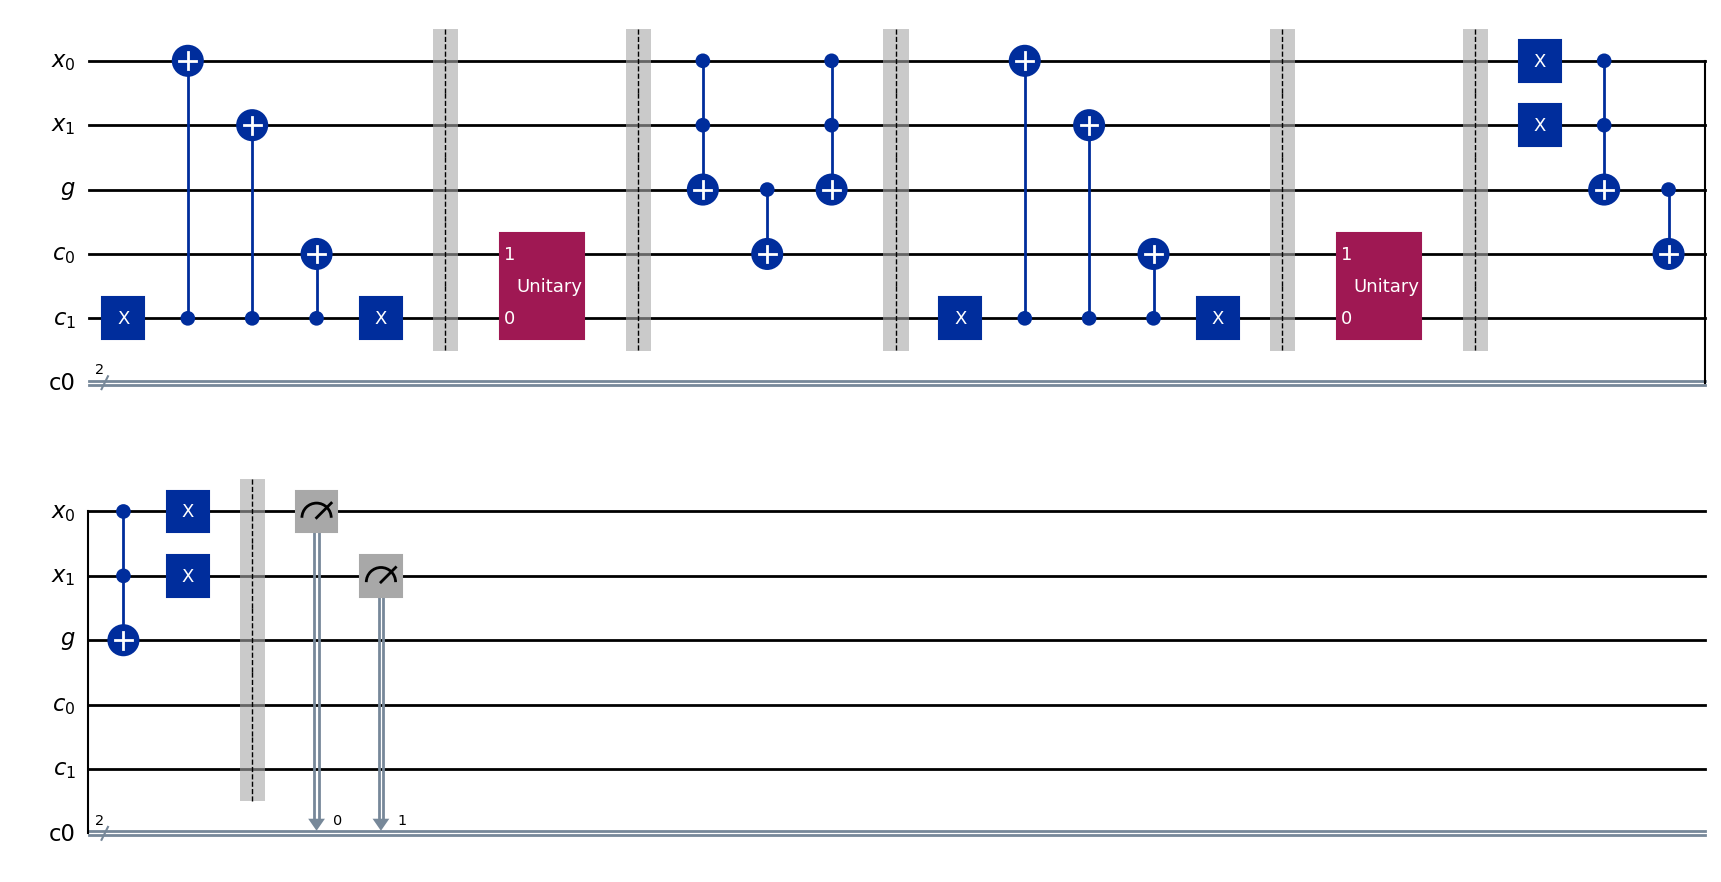

In [8]:
binaryString = ['00','11']
startString = ''
for char in binaryString[0]:
  startString = startString + '0'

qc, x, g, c, meas = createCircuit(len(binaryString[0]))

binaryString = binaryString + [startString]
basisEncoding(qc,x,g,c,binaryString)

counter = 0
while(counter < len(binaryString[0])):
  qc.measure(x[counter],meas[counter])
  counter = counter + 1

qc.draw('mpl')

#Para transpilar o circuito criado

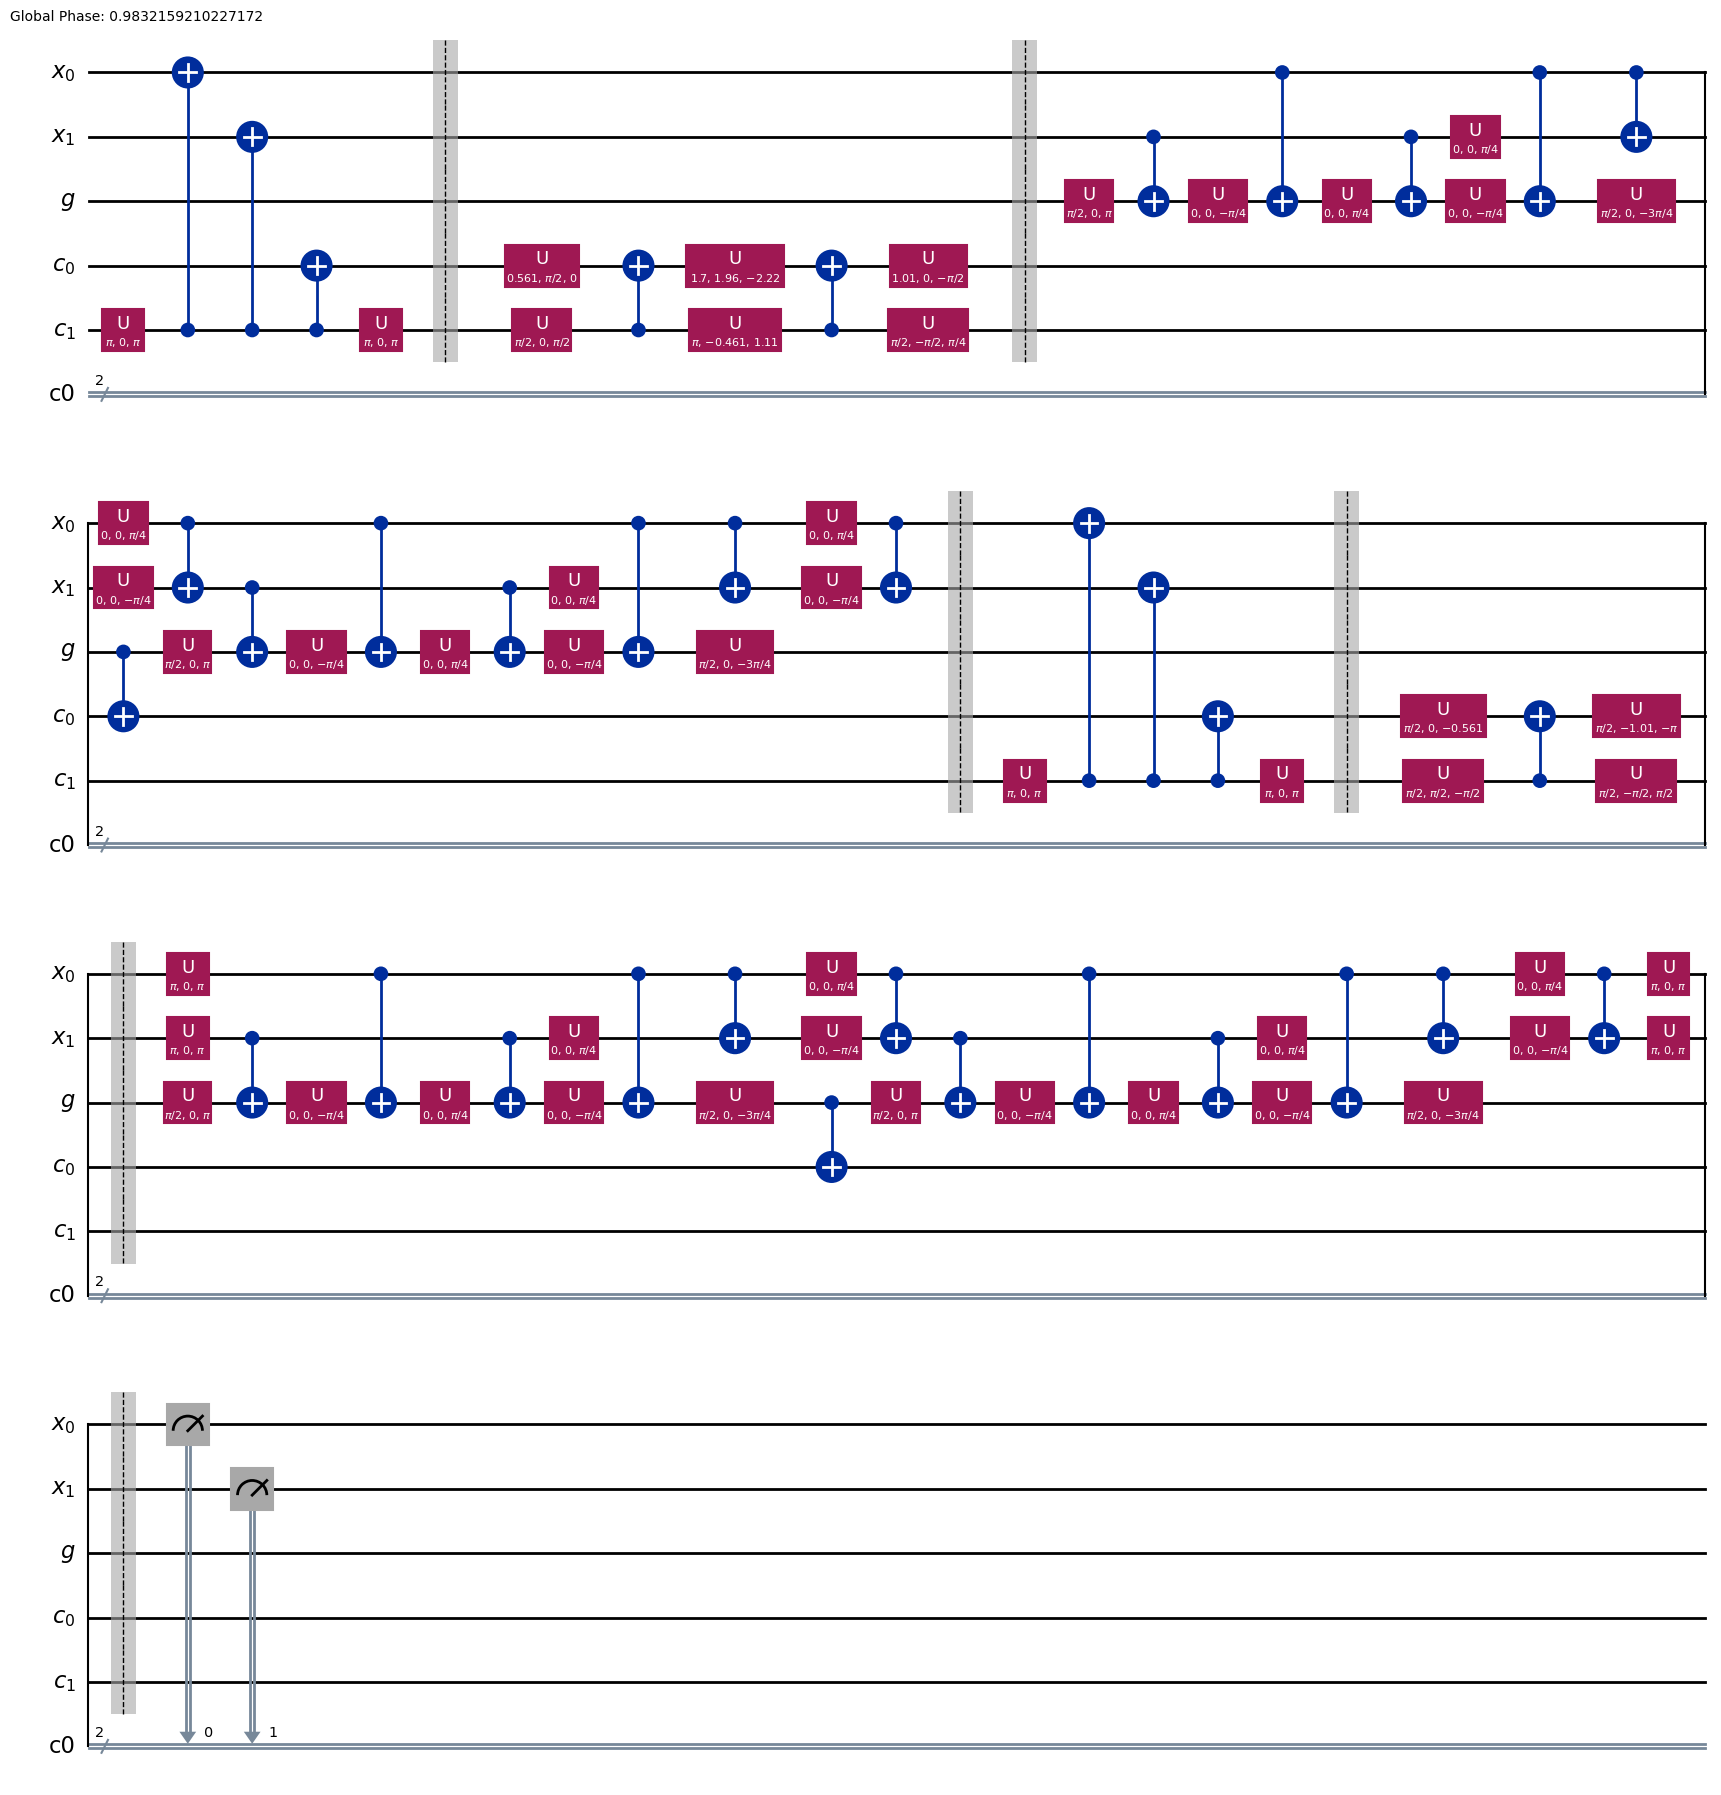

In [9]:
sim = Aer.get_backend('aer_simulator')

qc_t = transpile(qc, basis_gates=['u', 'cx'])

qc_t.draw('mpl')

#Para simular o circuito transpilado

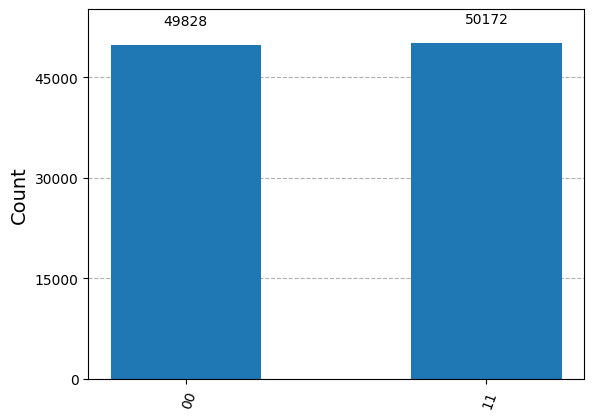

In [10]:
counts = sim.run(qc_t,shots = 100000).result().get_counts()
plot_histogram(counts)